<h1 align="center">Stone Soup Joint Probabiliistic Data Association (JPDA) Example</h1>
<h3 align="center">Demonstrating the capabilities of the Stone Soup JPDA filter</h3>

Initially, we'll set up some initial import and a plotting method which we'll use later.

In [16]:
#General imports and plotting
import datetime
import numpy as np

# Plotting
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('seaborn-colorblind')

Generating Data
----------------
First we'll create some models, which will be used to generate data.

This will include a 2D-position constant velocity transition model ($x$, $\dot{x}$, $y$ and $\dot{y}$) generated by combining two 1D models (this allows multiple models to be mixed and generation of *n*-dimension models).

In [17]:
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel,\
                                               ConstantVelocity
transition_model = CombinedLinearGaussianTransitionModel(
    (ConstantVelocity(1), ConstantVelocity(1)))

And a measurement model, which will map the position based detections ($x$ and $y$) to the position in the state.

In [18]:
from stonesoup.models.measurement.linear import LinearGaussian
measurement_model = LinearGaussian(
    ndim_state=4, mapping=[0, 2], noise_covar=np.diag([10, 10]))

Next we'll create a multi-target ground truth simulation in order to generate some data for testing the tracking algorithms. This utilises the *transition model* to generate the ground truth paths, initialised at random by sampling from a *Gaussian State*. A ground truth track/path at each timestamp is created at a random *birth rate* ($\lambda$ in Poisson distribution), and randomly killed by a *death probability*.

In [19]:
from stonesoup.simulator.simple import MultiTargetGroundTruthSimulator
from stonesoup.types.state import GaussianState
from stonesoup.types.array import StateVector, CovarianceMatrix

groundtruth_sim = MultiTargetGroundTruthSimulator(
    transition_model=transition_model,
    initial_state=GaussianState(
        StateVector([[0], [0], [0], [0]]),
        CovarianceMatrix(np.diag([1000000, 10, 1000000, 10]))),
    timestep=datetime.timedelta(seconds=5),
    birth_rate=0.3,
    death_probability=0.05
)

Next we'll create a detection simulator which will generate detections based on a *detection probability* about the ground truth, utilising the *measurement model*. This model will also create clutter in our defined *measurement range*.

In [20]:
from stonesoup.simulator.simple import SimpleDetectionSimulator

detection_sim = SimpleDetectionSimulator(
    groundtruth=groundtruth_sim,
    measurement_model=measurement_model,
    meas_range=np.array([[-1, 1], [-1, 1]])*5000,  # Area to generate clutter
    detection_probability=0.9,
    clutter_rate=3,
)

detections_source = detection_sim

Building JPDA Kalman tracker components
------------------------------------

With the detection data ready, we'll now build a JPDA Kalman tracker. For this we will need a Kalman predictor, which will utilise the same *transition model* we used in the ground truth simulator.

In [21]:
from stonesoup.predictor.kalman import KalmanPredictor
predictor = KalmanPredictor(transition_model)

And a PDA Kalman updater, utilising the same *measurement model* we used in the detection simulator.

In [22]:
from stonesoup.updater.kalman import KalmanUpdater
updater = KalmanUpdater(measurement_model)

We will also need a data associator to link detections to tracks for the update step.  For information on how the JPDA filter does this, please refer to the following references:

https://pdfs.semanticscholar.org/ecc7/0452659dfb0bc0190632f3169e53f9281395.pdf
http://www.cse.psu.edu/~rtc12/CSE598C/datassocPart2.pdf

In [23]:
from stonesoup.hypothesiser.probability import PDAHypothesiser
hypothesiser = PDAHypothesiser(predictor, updater, clutter_spatial_density=detection_sim.clutter_spatial_density, prob_detect=0.9, prob_gate=0.99)

In [24]:
from stonesoup.dataassociator.probability import JPDA
data_associator = JPDA(hypothesiser, 0.85)

And finally a initiator to generate tracks from unassociated detections, in this case a single point initiator generating a track for every unassociated detection.

In [25]:
from stonesoup.initiator.simple import SinglePointInitiator
initiator = SinglePointInitiator(
    GaussianState(np.array([[0], [0], [0], [0]]), np.diag([10000, 100, 10000, 1000])),
    measurement_model=measurement_model)

And a deleter to remove tracks, for this demo simply based on large covariance threshold.

In [26]:
from stonesoup.deleter.error import CovarianceBasedDeleter
deleter = CovarianceBasedDeleter(covar_trace_thresh=1E3)

Running the JPDA Kalman tracker
---------------------------
With all the components in place, we'll now construct the tracker with a multi target tracker. Since the JPDA filter is more computationally intensive than other algorithms (due to the combinatorial explosion of permutations of track/detection associations), this notebook prints the current simulation time being processed so that you can see that the algorithm is not "hanging".

In [27]:
from stonesoup.tracker.simple import MultiTargetMixtureTracker
tracker = MultiTargetMixtureTracker(
    initiator=initiator,
    deleter=deleter,
    detector=detections_source,
    data_associator=data_associator,
    updater=updater,
)

In [28]:
tracks = set()
groundtruth_paths = set()  # Store for plotting later
detections = set()  # Store for plotting later
for step, (time, ctracks) in enumerate(tracker.tracks_gen(), 1):
    tracks.update(ctracks)
    detections |= tracker.detector.detections
    if not step % 10:
        print("Step: {} Time: {}".format(step, time))

Step: 10 Time: 2020-04-08 15:18:26.314131
Step: 20 Time: 2020-04-08 15:19:16.314131
Step: 30 Time: 2020-04-08 15:20:06.314131
Step: 40 Time: 2020-04-08 15:20:56.314131
Step: 50 Time: 2020-04-08 15:21:46.314131
Step: 60 Time: 2020-04-08 15:22:36.314131
Step: 70 Time: 2020-04-08 15:23:26.314131
Step: 80 Time: 2020-04-08 15:24:16.314131
Step: 90 Time: 2020-04-08 15:25:06.314131
Step: 100 Time: 2020-04-08 15:25:56.314131


TimeRangePlottingMetric(title='Track plot', value=<Figure size 720x432 with 1 Axes>, generator=TwoDPlotter(track_indices=[0, 2], gtruth_indices=[0, 2], detection_indices=[0, 1]), time_range=TimeRange(start_timestamp=datetime.datetime(2020, 4, 8, 15, 17, 41, 314131), end_timestamp=datetime.datetime(2020, 4, 8, 15, 25, 56, 314131)))

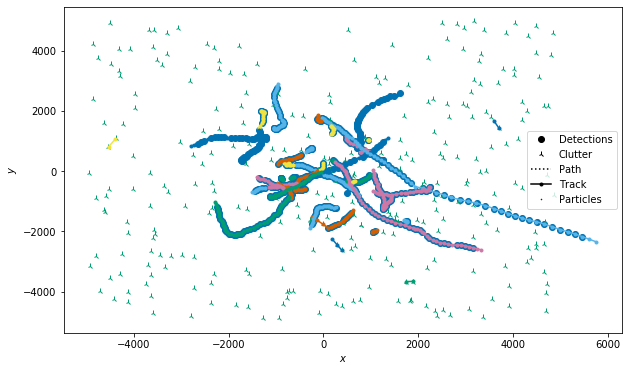

In [29]:
from stonesoup.metricgenerator.plotter import TwoDPlotter
TwoDPlotter([0, 2], [0, 2], [0, 1]).plot_tracks_truth_detections(tracks, groundtruth_paths, detections)

Note: Colours are random to help differentiate overlapping data.